In [1]:
%matplotlib notebook


In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import umap.umap_ as umap

from torch import optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import pandas as pd
import pickle

2023-04-21 22:39:20.412162: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 22:39:20.441163: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load transformer embedding corpus from serialization

In [3]:
file = open('./data/transformer_corpus', 'rb')
object_file = pickle.load(file)

In [4]:
print(len(object_file))

259087


In [5]:
df = pd.DataFrame(object_file, columns =['article', 'label','entities', 'embedding']) 
df.head()

,article,label,entities,embedding
0,health experts said early predict whether dema...,U.S. NEWS,[],"[[-0.042428464, -0.05273746, 0.01222564, 0.009..."
1,subdued passengers crew fled back aircraft con...,U.S. NEWS,[],"[[0.03151287, 0.010903334, -0.00016828088, 0.0..."
2,accidentally put toothpaste toddler toothbrush...,PARENTING,[],"[[-0.046831407, -0.055872813, 0.007849889, 0.0..."
3,amy cooper accused investment firm franklin te...,U.S. NEWS,[],"[[0.0052872994, -0.00012764185, 0.028915998, 0..."
4,woman seen working south carolina store thursd...,U.S. NEWS,[],"[[-0.09672863, 0.004548617, -0.08565861, 0.061..."


In [6]:
df['embedding'] = df['embedding'].map(lambda e: np.array(e, dtype=np.float))

df.head()


/tmp/ipykernel_51776/3706133808.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['embedding'] = df['embedding'].map(lambda e: np.array(e, dtype=np.float))


,article,label,entities,embedding
0,health experts said early predict whether dema...,U.S. NEWS,[],"[[-0.04242846369743347, -0.052737459540367126,..."
1,subdued passengers crew fled back aircraft con...,U.S. NEWS,[],"[[0.031512871384620667, 0.010903334245085716, ..."
2,accidentally put toothpaste toddler toothbrush...,PARENTING,[],"[[-0.0468314066529274, -0.05587281286716461, 0..."
3,amy cooper accused investment firm franklin te...,U.S. NEWS,[],"[[0.005287299398332834, -0.0001276418479392305..."
4,woman seen working south carolina store thursd...,U.S. NEWS,[],"[[-0.09672863036394119, 0.004548617172986269, ..."


In [7]:
unique = list(np.unique(df['label']))
df['label_num'] = df['label'].map(lambda e: unique.index(e))


In [8]:
df.head()
print(df.shape)
df.dropna()
print(df.shape)


(259087, 5)
(259087, 5)


In [9]:

#mat_embeddings = np.array(np.zeros(384))
mat_embeddings = df['embedding'].map(lambda e: np.array(e[0])).to_numpy()
labels = df['label_num'].to_numpy().astype(np.float)
#print(embeddings[0].shape)
m_em = np.stack(mat_embeddings)
print(m_em)
print(m_em.shape)

/tmp/ipykernel_51776/687884188.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = df['label_num'].to_numpy().astype(np.float)


[[-0.04242846 -0.05273746  0.01222564 ... -0.12872475 -0.0369744
   0.07397687]
 [ 0.03151287  0.01090333 -0.00016828 ...  0.08744578 -0.03970892
  -0.0353999 ]
 [-0.04683141 -0.05587281  0.00784989 ... -0.00730067  0.06827408
   0.04921927]
 ...
 [ 0.00263818  0.01890752 -0.00195855 ...  0.07984449 -0.02753437
   0.01261969]
 [-0.0177998   0.05252247  0.00633611 ... -0.00095687 -0.03967441
   0.06988091]
 [-0.05717564 -0.00429257  0.01951273 ... -0.01829587 -0.07201405
   0.0024681 ]]
(259087, 384)


<IPython.core.display.Javascript object>


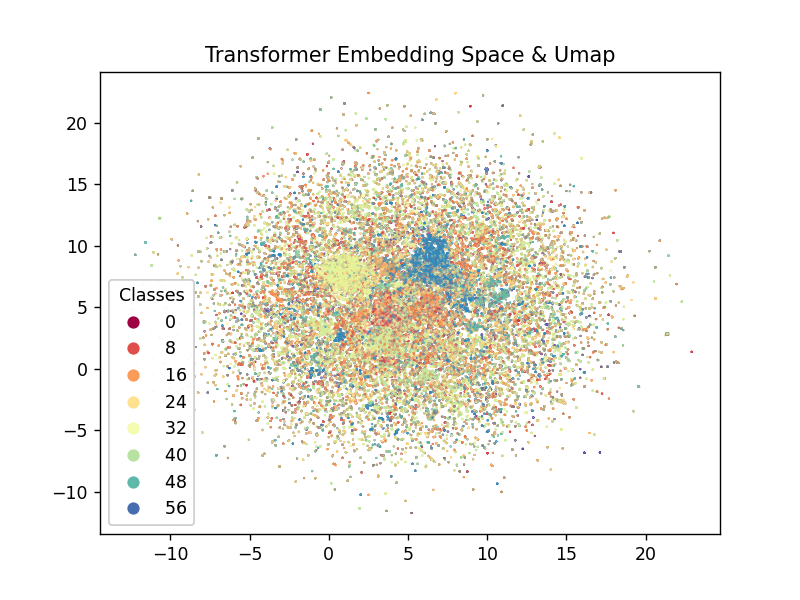

In [10]:




umap_embedding = umap.UMAP(n_neighbors = 10).fit_transform(m_em)
fig, ax = plt.subplots()
#labels_num = np.array([d.y[name] for name in test_data.y])
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], s=0.03, c=df['label_num'], cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.rcParams['figure.figsize'] = [20, 20]

plt.title("Transformer Embedding Space & Umap")
fig.savefig('transformerembeddingspace.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
plt.show()

In [13]:
from sklearn.decomposition import PCA
ncomp_pca = 30
pca_70 = PCA(n_components = ncomp_pca, random_state=2000,svd_solver = 'full')
pca_70.fit(m_em)
m_em2 = pca_70.transform(m_em).astype(np.float64)

In [ ]:
umap_embedding = umap.UMAP(n_neighbors = 10).fit_transform(m_em2)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], umap_embedding.T[2], s=0.03, c=df['label_num'], cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.rcParams['figure.figsize'] = [20, 20]

plt.title("PCA Reduced Transformer Embedding, n_components = " + str(ncomp_pca) +  " Embedding Space & Umap")
fig.savefig('transformer&pca.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
plt.show()
#test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
#train_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(umap_embedding.T[0], umap_embedding.T[1], umap_embedding.T[2], s=0.03, c=df['label_num'], cmap='Spectral')
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.rcParams['figure.figsize'] = [20, 20]

plt.title("PCA Reduced Transformer Embedding, n_components = " + str(ncomp_pca) +  " Embedding Space & Umap")
fig.savefig('transformer&pca.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
plt.show()
